# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS

In [1]:
import duckdb, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 1673025012
np.random.seed(RANDOM_SEED)

### Options

In [2]:
START_YEAR = 2005

SELECT_HYPERPARAMETERS = True

### Load data

In [3]:
con = duckdb.connect("./data/us_births.db", read_only=True)

df = con.execute(
    f"""
    SELECT
        -- (training label) indicated if C or P, otherwise not
        CASE
            WHEN COALESCE (ca_down, ca_downs) = 'C' THEN 1::UTINYINT
            WHEN COALESCE (ca_down, ca_downs) = 'P' THEN 1::UTINYINT
            ELSE 0::UTINYINT
        END AS ca_down_c_or_p,
        -- ==================== date of birth ====================
        year,
        -- month of birth
        dob_mm,
        -- day of week of birth (1-7)
        dob_wk,
        -- time of birth (0000-2359)
        CASE
            WHEN dob_tt >= 0 AND dob_tt <= 2359 THEN dob_tt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dob_tt,
        -- ==================== birth location ====================
        -- birth place (1: hospital, 2: not hospital, 3: unknown/not stated)
        bfacil3,
        -- ==================== characteristics of baby ====================
        -- sex of baby
        CASE
            WHEN sex = 'M' THEN 1::UTINYINT
            WHEN sex = 'F' THEN 0::UTINYINT
            ELSE NULL
        END AS sex,
        -- birth weight (grams)
        CASE
            WHEN dbwt >= 227 AND dbwt <= 8165 THEN dbwt
            -- we ignore "Not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS dbwt,
        -- ==================== characteristics of pregnancy ====================
        -- plurality (1: single... 4 quadpruplet or higher)
        dplural,
        -- month prenatal care began (1 to 10, 0: no prenatal care)
        CASE
            WHEN precare >= 0 AND precare <= 10 THEN precare
            WHEN precare = 99 THEN precare
            ELSE NULL
        END AS precare,
        -- combined gestation estimate
        CASE
            WHEN gestrec10 >= 1 AND gestrec10 <= 10 THEN gestrec10
            WHEN gestrec10 = 99 THEN gestrec10
            ELSE NULL
        END AS gestrec10,
        -- pre-pregnancy weight recode (in pounds)
        CASE
            WHEN pwgt_r >= 75 AND pwgt_r <= 375 THEN pwgt_r
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS pwgt_r,
        -- weight gain in pounds (98 = 98+)
        CASE
            WHEN wtgain >= 0 AND wtgain <= 98 THEN wtgain
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END AS wtgain,
        -- maternal body mass index
        CASE
            WHEN bmi >= 13.0 AND bmi < 69.9 THEN bmi
            -- we ignore "Unknown or not stated" as we treat this variable as numeric rather than categorical
            ELSE NULL
        END
        AS bmi,
        -- ==================== pregnancy risk factors ====================
        -- pre-pregnancy diabetes
        CASE
            WHEN rf_pdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_pdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_pdiab,
        -- gestational diabetes
        CASE
            WHEN rf_gdiab = 'Y' THEN 1::UTINYINT
            WHEN rf_gdiab = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_gdiab,
        -- pre-pregnancy hypertension
        CASE
            WHEN rf_phype = 'Y' THEN 1::UTINYINT
            WHEN rf_phype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_phype,
        -- gestational hypertension
        CASE
            WHEN rf_ghype = 'Y' THEN 1::UTINYINT
            WHEN rf_ghype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ghype,
        -- hypertension eclampsia
        CASE
            WHEN rf_ehype = 'Y' THEN 1::UTINYINT
            WHEN rf_ehype = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ehype,
        -- previous preterm birth
        CASE
            WHEN rf_ppterm = 'Y' THEN 1::UTINYINT
            WHEN rf_ppterm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_ppterm,
        -- infertility treatment used
        CASE
            WHEN rf_inftr = 'Y' THEN 1::UTINYINT
            WHEN rf_inftr = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_inftr,
        -- fertility enhancing drugs
        CASE
            WHEN rf_fedrg = 'Y' THEN 1::UTINYINT
            WHEN rf_fedrg = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_fedrg,
        -- asst. reproductive technology
        CASE
            WHEN rf_artec = 'Y' THEN 1::UTINYINT
            WHEN rf_artec = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS rf_artec,
        -- no risk factors reported
        CASE
            WHEN no_risks <= 1 THEN no_risks
            ELSE NULL
        END AS no_risks,
        -- ==================== labor and delivery ====================
        -- induction of labor
        CASE
            WHEN ld_indl = 'Y' THEN 1::UTINYINT
            WHEN ld_indl = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_indl,
        -- augmentation of labor
        CASE
            WHEN ld_augm = 'Y' THEN 1::UTINYINT
            WHEN ld_augm = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ld_augm,
        -- fetal presentation at delivery
        CASE
            WHEN me_pres >= 1 AND me_pres <= 3 THEN me_pres
            WHEN me_pres = 9 THEN me_pres
            ELSE NULL
        END AS me_pres,
        -- delivery method recode
        CASE
            WHEN dmeth_rec >= 1 AND dmeth_rec <= 2 THEN dmeth_rec
            WHEN dmeth_rec = 9 THEN dmeth_rec
            ELSE NULL
        END AS dmeth_rec,
        -- ==================== newborn health ====================
        -- five minute apgar score
        CASE
            WHEN apgar5 >= 10 AND apgar5 <= 10 THEN apgar5
            WHEN apgar5 = 99 THEN apgar5
            ELSE NULL
        END AS apgar5,
        -- ten minute apgar score
        CASE
            WHEN apgar10 >= 10 AND apgar10 <= 10 THEN apgar10
            WHEN apgar10 = 99 THEN apgar10
            ELSE NULL
        END AS apgar10,
        -- assisted ventilation (immediately)
        CASE
            WHEN ab_aven1 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven1 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven1,
        -- assisted ventilation > 6 hrs
        CASE
            WHEN ab_aven6 = 'Y' THEN 1::UTINYINT
            WHEN ab_aven6 = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_aven6,
        -- admitted to nicu
        CASE
            WHEN ab_nicu = 'Y' THEN 1::UTINYINT
            WHEN ab_nicu = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_nicu,
        -- surfactant
        CASE
            WHEN ab_surf = 'Y' THEN 1::UTINYINT
            WHEN ab_surf = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_surf,
        -- antibiotics for newborn
        CASE
            WHEN ab_anti = 'Y' THEN 1::UTINYINT
            WHEN ab_anti = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_anti,
        -- seizures
        CASE
            WHEN ab_seiz = 'Y' THEN 1::UTINYINT
            WHEN ab_seiz = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ab_seiz,
        -- no_abnorm
        CASE
            WHEN no_abnorm >= 0 AND no_abnorm <= 1 THEN no_abnorm
            WHEN no_abnorm = 9 THEN no_abnorm
            ELSE NULL
        END AS no_abnorm,
        -- ==================== identified disorders ====================
        -- congenital disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            ELSE NULL
        END
        AS ca_disor,
        -- anencephaly
        CASE
            WHEN ca_anen = 'Y' THEN 1::UTINYINT
            WHEN ca_anen = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_anen,
        -- meningomyelocele / spina bifida
        CASE
            WHEN ca_mnsb = 'Y' THEN 1::UTINYINT
            WHEN ca_mnsb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_mnsb,
        -- congenital heart defect
        CASE
            WHEN ca_cchd = 'Y' THEN 1::UTINYINT
            WHEN ca_cchd = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cchd,
        -- ca_cdh
        CASE
            WHEN ca_cdh = 'Y' THEN 1::UTINYINT
            WHEN ca_cdh = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cdh,
        -- omphalocele
        CASE
            WHEN ca_omph = 'Y' THEN 1::UTINYINT
            WHEN ca_omph = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_omph,
        -- gastroschisis
        CASE
            WHEN ca_gast = 'Y' THEN 1::UTINYINT
            WHEN ca_gast = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_gast,
        -- limb reduction defect
        CASE
            WHEN ca_limb = 'Y' THEN 1::UTINYINT
            WHEN ca_limb = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_limb,
        -- cleft lip w/ or w/o cleft palate
        CASE
            WHEN ca_cleft = 'Y' THEN 1::UTINYINT
            WHEN ca_cleft = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_cleft,
        -- cleft palate alone
        CASE
            WHEN ca_clpal = 'Y' THEN 1::UTINYINT
            WHEN ca_clpal = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_clpal,
        -- Hypospadias
        CASE
            WHEN ca_hypo = 'Y' THEN 1::UTINYINT
            WHEN ca_hypo = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS ca_hypo,
        -- suspected chromosomal disorder
        CASE
            WHEN ca_disor = 'C' THEN 1::UTINYINT
            WHEN ca_disor = 'P' THEN 2::UTINYINT
            WHEN ca_disor = 'N' THEN 0::UTINYINT
            WHEN ca_disor = 'U' THEN 9::UTINYINT
            ELSE NULL
        END AS ca_disor,
        -- no_congen
        CASE
            WHEN no_congen >= 0 AND no_congen <= 1 THEN no_congen
            WHEN no_congen = 9 THEN no_congen
            ELSE NULL
        END AS no_congen,
        -- ==================== maternal characteristics ====================
        -- maternal age in years
        mage_c,
        -- maternal education
        CASE
            WHEN meduc >= 0 AND meduc < 10 THEN meduc
            ELSE NULL
        END AS meduc,
        -- maternal race
        CASE
            WHEN  mracehisp >= 1 AND mracehisp <= 8 THEN mracehisp
            ELSE NULL
        END AS mracehisp,
        -- ==================== paternal characteristics ====================
        -- father's combined age in years
        CASE
            WHEN fagecomb >= 9 AND fagecomb < 99 THEN fagecomb
            ELSE NULL
        END AS fagecomb,
        -- paternal education
        CASE
            WHEN  feduc < 9 THEN feduc
            ELSE NULL
        END AS feduc,
        -- paternal race
        CASE
            WHEN  fracehisp >= 1 AND fracehisp <= 10 THEN fracehisp
            ELSE NULL
        END AS fracehisp,
        -- ==================== socio-economic indicators ====================
        -- payment source recode
        CASE
            WHEN  pay_rec < 5 THEN pay_rec
            ELSE NULL
        END AS pay_rec,
        -- supplemental nutrition program for women, infants, and children
        CASE
            WHEN wic = 'Y' THEN 1::UTINYINT
            WHEN wic = 'N' THEN 0::UTINYINT
            ELSE NULL
        END AS wic
    FROM
        us_births
    WHERE year >= {START_YEAR}
    ORDER BY
        year, dob_mm
    """
).df()

con.close()

df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,ca_down_c_or_p,year,dob_mm,dob_wk,dob_tt,bfacil3,sex,dbwt,dplural,precare,...,ca_disor_1,no_congen,mage_c,meduc,mracehisp,fagecomb,feduc,fracehisp,pay_rec,wic
0,0,2005,1,3,<NA>,2,0,3402,1,<NA>,...,<NA>,<NA>,32,<NA>,6,<NA>,<NA>,9,<NA>,<NA>
1,0,2005,1,3,<NA>,2,0,<NA>,1,<NA>,...,<NA>,<NA>,29,<NA>,<NA>,<NA>,<NA>,9,<NA>,<NA>
2,0,2005,1,6,<NA>,2,0,3657,1,<NA>,...,<NA>,<NA>,37,<NA>,6,<NA>,<NA>,6,<NA>,<NA>
3,0,2005,1,6,<NA>,2,1,3430,1,<NA>,...,<NA>,<NA>,38,<NA>,6,<NA>,<NA>,6,<NA>,<NA>
4,0,2005,1,7,<NA>,1,0,2630,1,<NA>,...,<NA>,<NA>,22,<NA>,1,<NA>,<NA>,9,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78581855,0,2024,12,3,<NA>,1,0,3600,1,3,...,0,1,31,3,1,41,5,6,1,1
78581856,0,2024,12,4,<NA>,1,0,3090,1,2,...,0,1,31,3,7,37,3,7,1,1
78581857,0,2024,12,1,45,1,1,2512,1,3,...,0,1,29,3,6,<NA>,<NA>,8,1,1
78581858,0,2024,12,1,<NA>,1,0,2865,1,3,...,0,1,35,2,7,36,2,7,4,1


#### Missing values

### Initial features

In [4]:
numeric = [
    "year",
    "dbwt",
    "pwgt_r",
    "wtgain",
    "bmi",
    "mage_c",
    "fagecomb",
]

categorical = [
    "dob_mm",
    "dob_wk",
    "bfacil3",
    "sex",
    "precare",
    "gestrec10",
    "rf_pdiab",
    "rf_gdiab",
    "rf_phype",
    "rf_ghype",
    "rf_ehype",
    "rf_ppterm",
    "rf_inftr",
    "rf_fedrg",
    "rf_artec",
    "no_risks",
    "ld_indl",
    "ld_augm",
    "me_pres",
    "dmeth_rec",
    "apgar5",
    "apgar10",
    "ab_aven1",
    "ab_aven6",
    "ab_nicu",
    "ab_surf",
    "ab_anti",
    "ab_seiz",
    "no_abnorm",
    "ca_anen",
    "ca_mnsb",
    "ca_cchd",
    "ca_cdh",
    "ca_omph",
    "ca_gast",
    "ca_limb",
    "ca_cleft",
    "ca_clpal",
    "ca_hypo",
    "ca_disor",
    "no_congen",
    "meduc",
    "mracehisp",
    "feduc",
    "fracehisp",
    "pay_rec",
    "wic",
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_or_p"]


In [5]:

print(f"{X.shape[0]} {X.shape[1]}")

78581860 54


### Prepare training and validation data

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=y
)

train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical,
    free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False
)

In [7]:
neg_count = (y_train == 0).count()
pos_count = (y_train == 1).count()
scale_pos_weight = neg_count / pos_count

In [ ]:
train_set = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_set = lgb.Dataset(X_valid, label=y_valid, reference=train_set, free_raw_data=False)

### Hyperparameter tuning

In [ ]:
dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain, free_raw_data=False)

def objective(trial):
    params = {
        "objective": "binary",
        "metric": ["average_precision", "binary_logloss"],
        "boosting_type": "gbdt",

        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.15, log=True),
        "max_bin": trial.suggest_int("max_bin", 63, 255),

        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 20000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),

        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),

        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),

        "scale_pos_weight": scale_pos_weight,

        "seed": RANDOM_SEED,
        "force_col_wise": True,
        "num_threads": 22,
        "verbosity": 1,
        # If you use categorical features, pass categorical_feature to Dataset or train().
    }

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10),
            lgb.log_evaluation(period=5),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=50)

print(study.best_params, study.best_value)

[I 2025-12-18 14:07:43,537] A new study created in memory with name: no-name-e53a0236-a8ec-476b-9756-5dc1bb8a8709


[LightGBM] [Info] Number of positive: 23862, number of negative: 54983440
[LightGBM] [Info] Total Bins 836
[LightGBM] [Info] Number of data points in the train set: 55007302, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000434 -> initscore=-7.742500
[LightGBM] [Info] Start training from score -7.742500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [ ]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "verbosity": 1,
    "seed": RANDOM_SEED,
    "num_threads": 24,
}

# Optuna best params (contains only the hyperparameters you searched)
best = study.best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}

In [9]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=5)
    ]
)


[LightGBM] [Info] Number of positive: 23927, number of negative: 49243158
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 49267085, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000486 -> initscore=-7.629518
[LightGBM] [Info] Start training from score -7.629518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	train's average_precision: 0.021934	train's auc: 0.878657	valid's average_precision: 0.0207262	valid's auc: 0.875775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

To improve on:

- Validation AUC: 0.8907
- Validation AUPRC: 0.0301

In [10]:
gbm.save_model(f"./output/features_model_{datetime.now().strftime("%Y%m%d%H%M")}.txt", num_iteration=gbm.best_iteration)

In [11]:
y_valid_pred_proba = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

auc = roc_auc_score(y_valid, y_valid_pred_proba)
aupr = average_precision_score(y_valid, y_valid_pred_proba)

print(f"Validation AUC:  {auc:.4f}")
print(f"Validation AUPRC:{aupr:.4f}")


Validation AUC:  0.8866
Validation AUPRC:0.0276


In [12]:
lr_age = LogisticRegression(max_iter=1000)
lr_age.fit(X_train[["mage_c"]], y_train)
p_age = lr_age.predict_proba(X_valid[["mage_c"]])[:, 1]
print("AUC (age only):", roc_auc_score(y_valid, p_age))


AUC (age only): 0.7038245350469057


In [13]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame({
    "feature": features,
    "importance_gain": importance_gain
}).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(f"./output/importance_gain_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

df_imp_gain

,feature,importance_gain
10,ab_nicu,190175.003531
1,mage_c,153825.585404
19,ca_disor,103500.057083
20,ca_cchd,74264.301560
7,dbwt,67169.903851
8,ab_aven1,32943.517469
5,wtgain,20796.028590
2,fagecomb,20335.653022
23,bmi,19229.290508
3,pwgt_r,18410.831760


In [14]:
pos_idx = y_valid[y_valid == 1].index
neg_idx = y_valid[y_valid == 0].index

n_pos_eval = min(10_000, len(pos_idx))
n_neg_eval = min(10 * n_pos_eval, len(neg_idx))  # 10:1 negatives:positives

rng = np.random.default_rng(123)

pos_sample = rng.choice(pos_idx, size=n_pos_eval, replace=False)
neg_sample = rng.choice(neg_idx, size=n_neg_eval, replace=False)

eval_idx = np.concatenate([pos_sample, neg_sample])
eval_idx = rng.permutation(eval_idx)  # shuffle

X_eval = X_valid.loc[eval_idx]
y_eval = y_valid.loc[eval_idx]


In [15]:


def ap_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1]
    return average_precision_score(y, proba)


class LGBMWrapper:
    def __init__(self, booster):
        self.booster = booster

    def fit(self, X, y=None):
        # Required by sklearn API; we don't actually train here.
        return self

    def predict_proba(self, X):
        # LightGBM Booster.predict gives P(y=1) for binary by default
        p1 = self.booster.predict(X)
        p0 = 1.0 - p1
        return np.column_stack([p0, p1])

    def predict(self, X):
        p1 = self.booster.predict(X)
        return (p1 >= 0.5).astype(int)


model_wrapped = LGBMWrapper(gbm)


In [16]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ap_scorer,
    n_repeats=5,  # small but OK given size
    n_jobs=4,  # adjust for your machine
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame({
    "feature": X_eval.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(f"./output/permutation_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)
perm_importance

,feature,importance_mean,importance_std
10,ab_nicu,0.184827,0.001703
1,mage_c,0.144142,0.002261
19,ca_disor,0.114022,0.001841
20,ca_cchd,0.054236,0.001482
7,dbwt,0.049865,0.000509
8,ab_aven1,0.014519,0.000641
17,dmeth_rec,0.007353,0.000434
12,ab_anti,0.006533,0.000332
5,wtgain,0.005802,0.000536
24,pay_rec,0.004165,0.000329


In [17]:
# e.g. take all positives from X_eval and match them 1:2 with negatives
pos_eval_idx = y_eval[y_eval == 1].index
neg_eval_idx = y_eval[y_eval == 0].index

n_pos_shap = min(5_000, len(pos_eval_idx))
n_neg_shap = min(2 * n_pos_shap, len(neg_eval_idx))  # 2:1 neg:pos

pos_shap = rng.choice(pos_eval_idx, size=n_pos_shap, replace=False)
neg_shap = rng.choice(neg_eval_idx, size=n_neg_shap, replace=False)

shap_idx = np.concatenate([pos_shap, neg_shap])
shap_idx = rng.permutation(shap_idx)

X_shap = X_eval.loc[shap_idx]
y_shap = y_eval.loc[shap_idx]


In [18]:


# Tell SHAP this is a LightGBM model
explainer = shap.TreeExplainer(gbm)
explanation = explainer(X_shap)
shap_values = explanation.values

# Handle both cases: list or array
if isinstance(shap_values, list):
    shap_pos = shap_values[1]  # SHAP values for positive class
else:
    shap_pos = shap_values  # already positive class

# Global importance: mean |SHAP|
shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": np.mean(np.abs(shap_pos), axis=0),
}).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(f"./output/shap_importance_{datetime.now().strftime("%Y%m%d%H%M")}.csv", index=False)

shap_importance


,feature,mean_abs_shap
1,mage_c,0.538942
10,ab_nicu,0.528574
7,dbwt,0.400964
19,ca_disor,0.200980
20,ca_cchd,0.135979
8,ab_aven1,0.121368
5,wtgain,0.097562
22,ca_omph,0.090975
3,pwgt_r,0.083550
0,year,0.079568



Feature: year


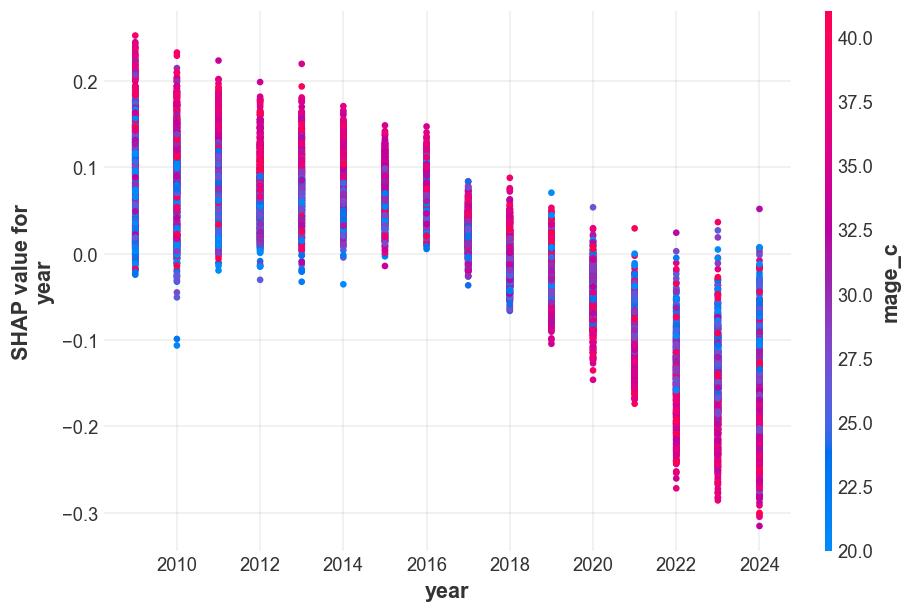


Feature: mage_c


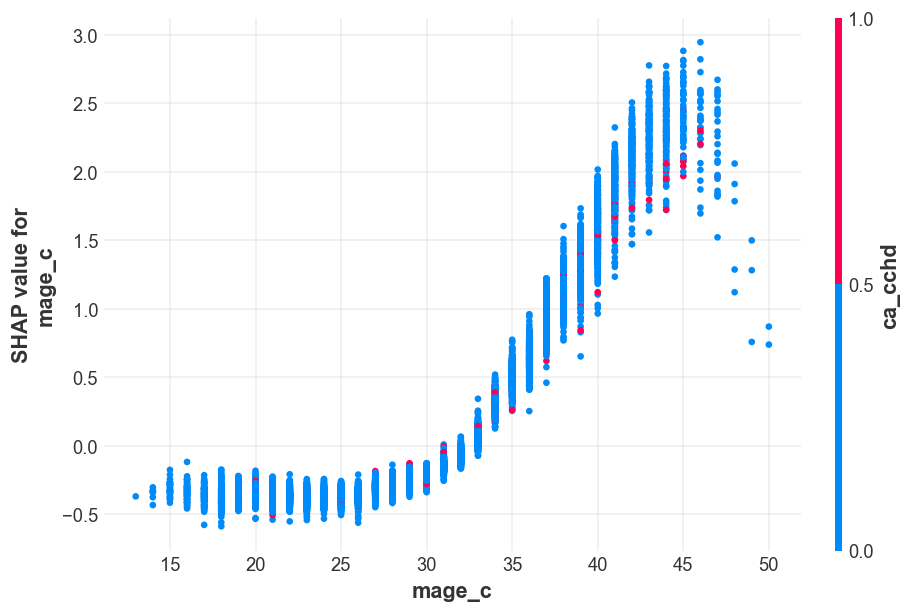


Feature: fagecomb


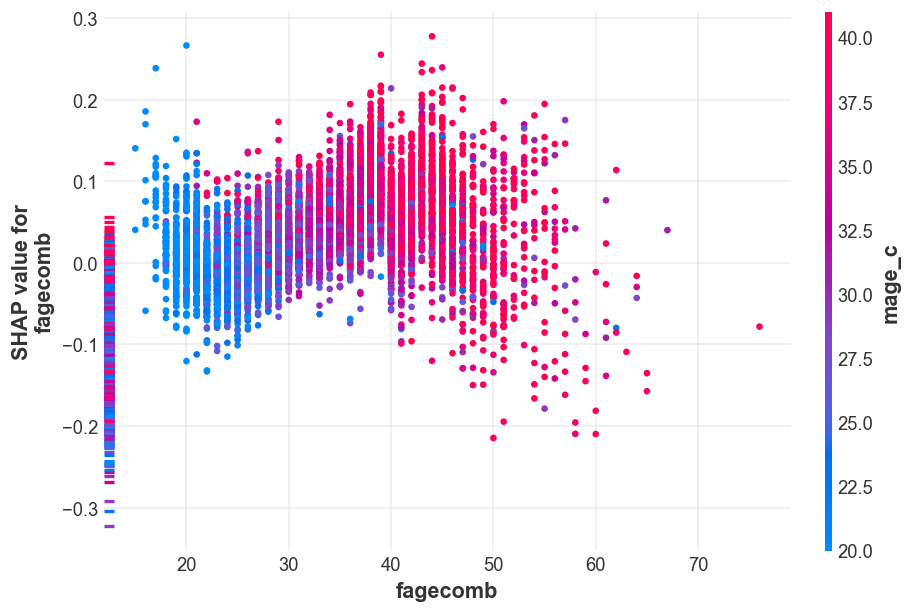


Feature: pwgt_r


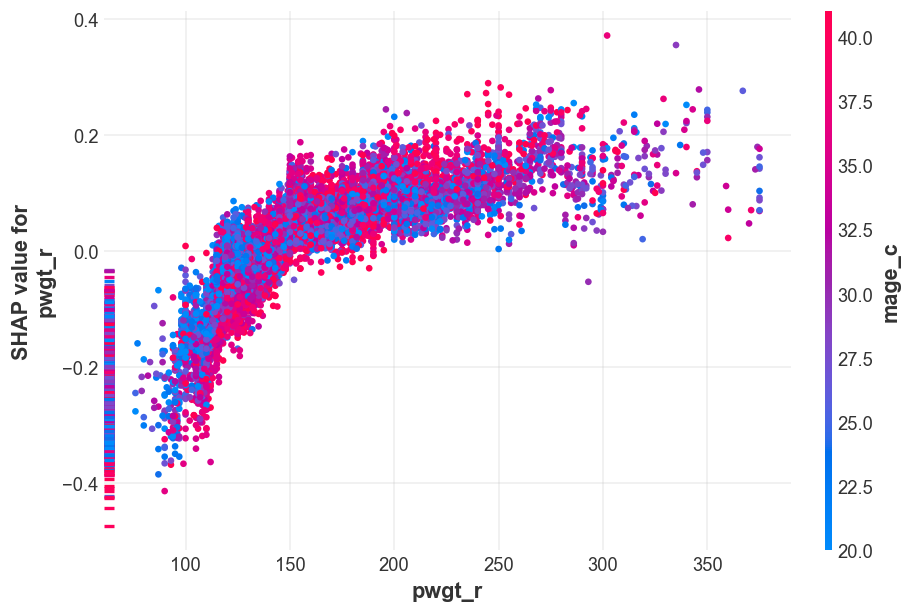


Feature: dwgt_r


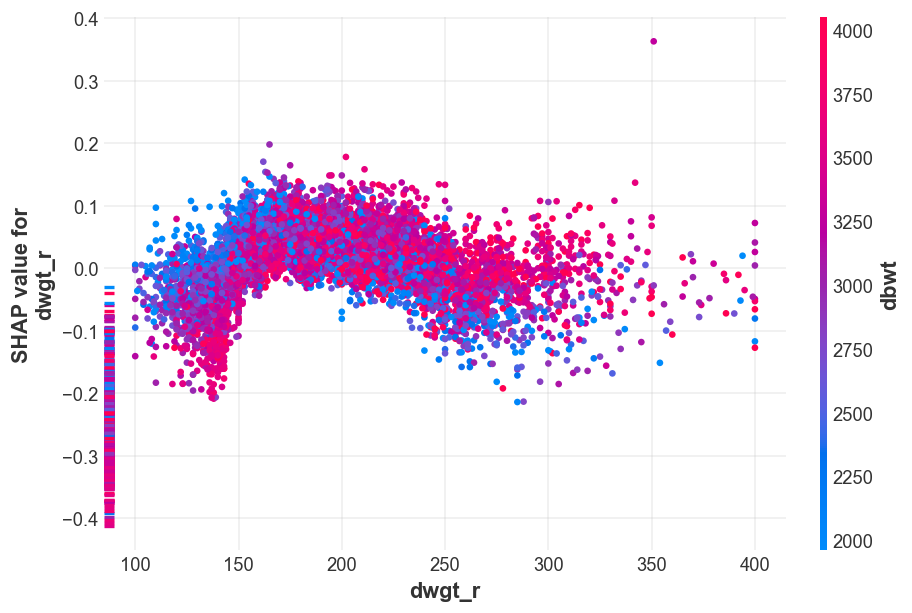


Feature: wtgain


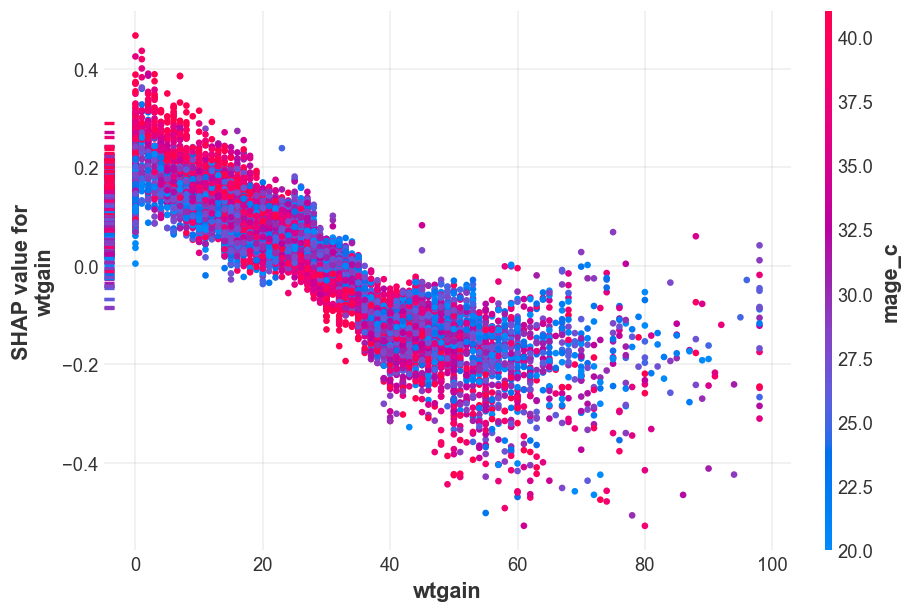


Feature: rf_ppterm


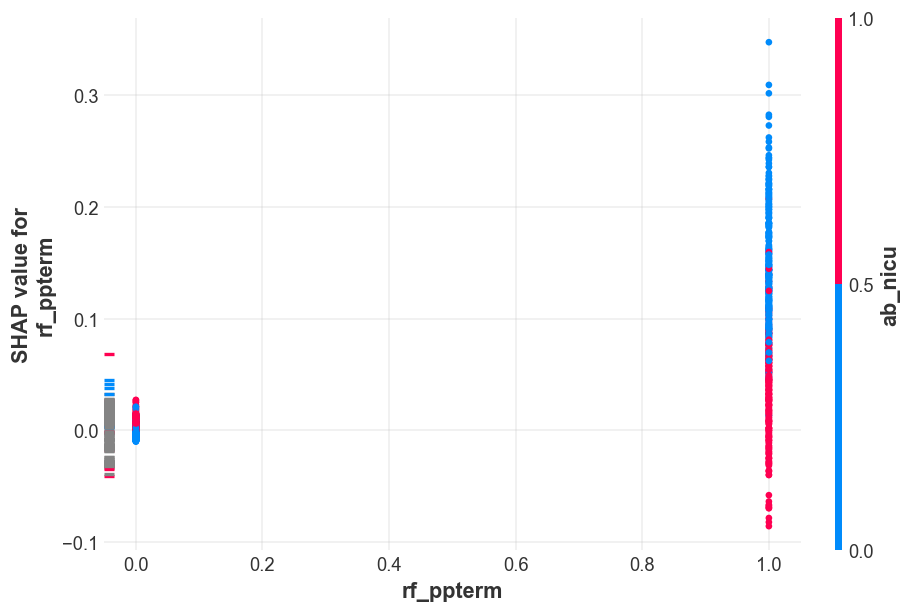


Feature: dbwt


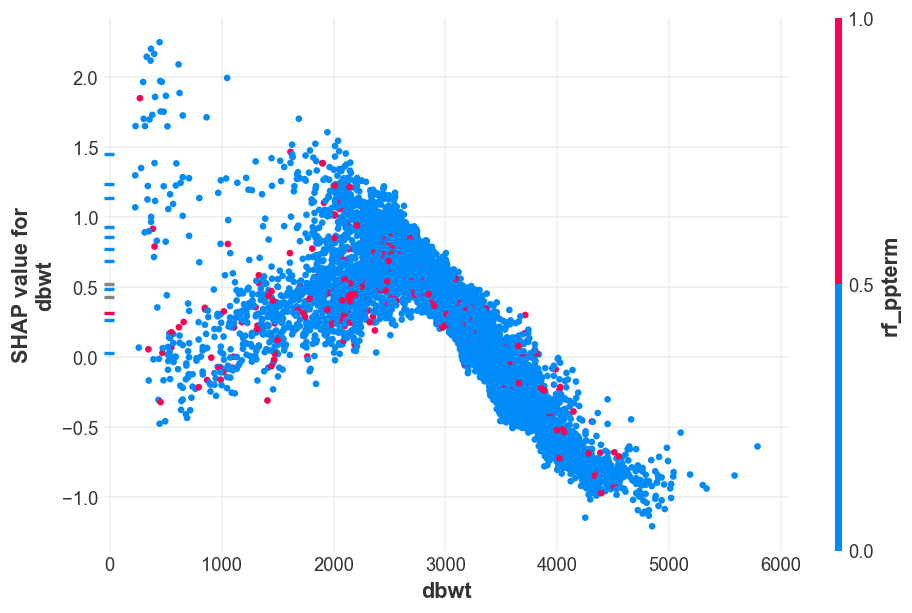


Feature: ab_aven1


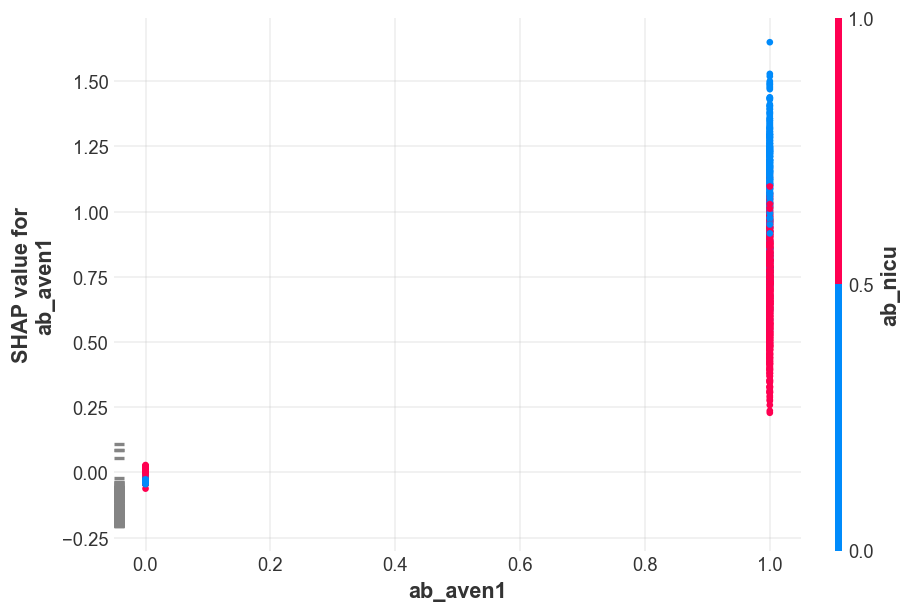


Feature: ab_aven6


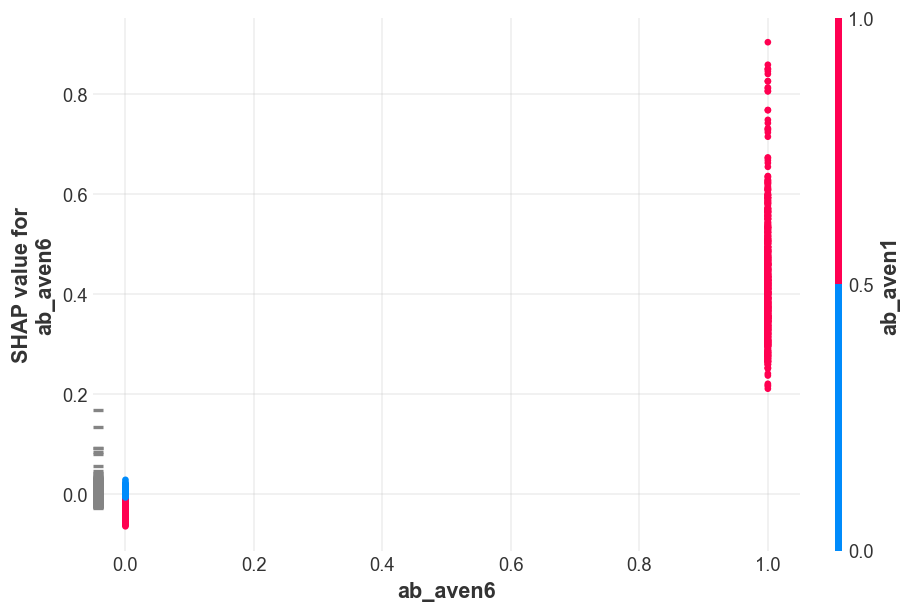


Feature: ab_nicu


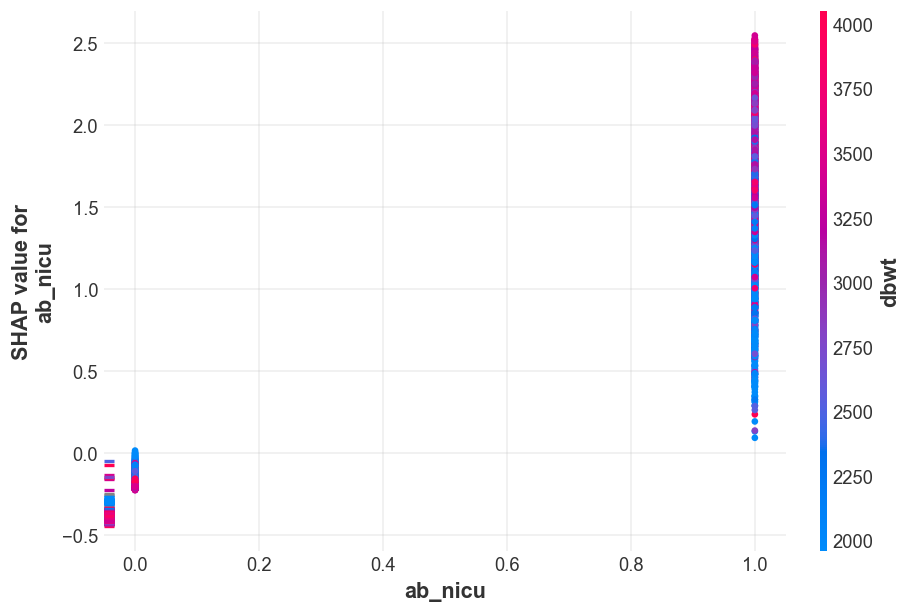


Feature: ab_surf


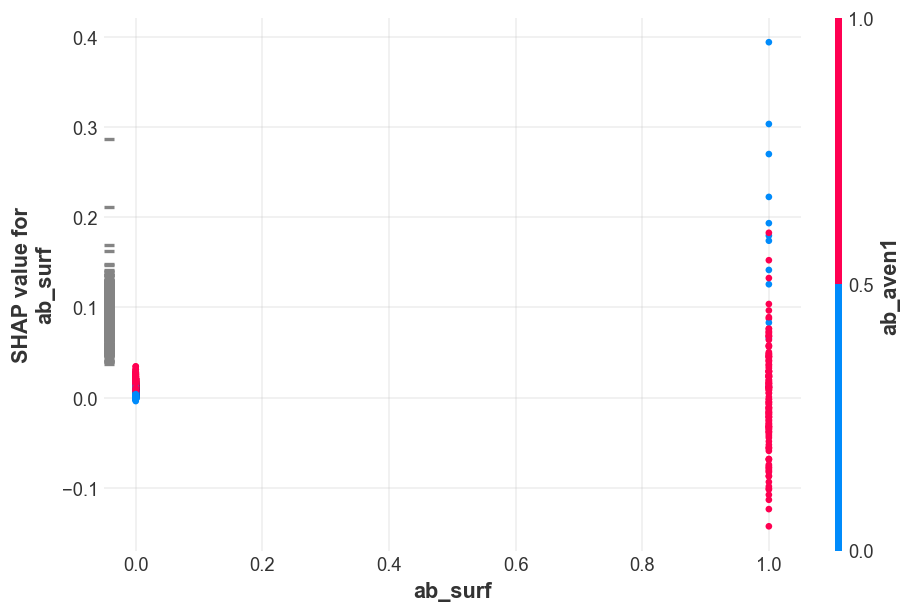


Feature: ab_anti


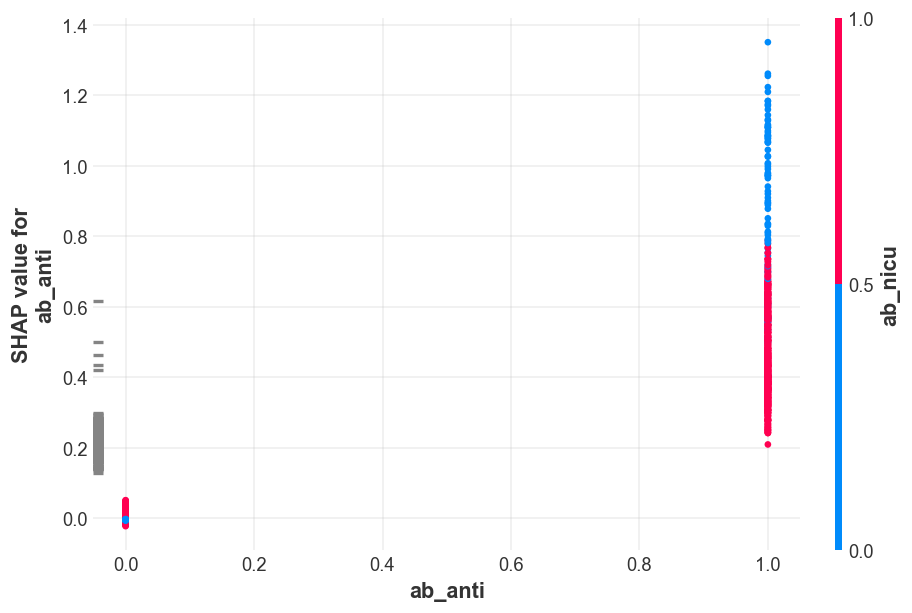


Feature: ab_seiz


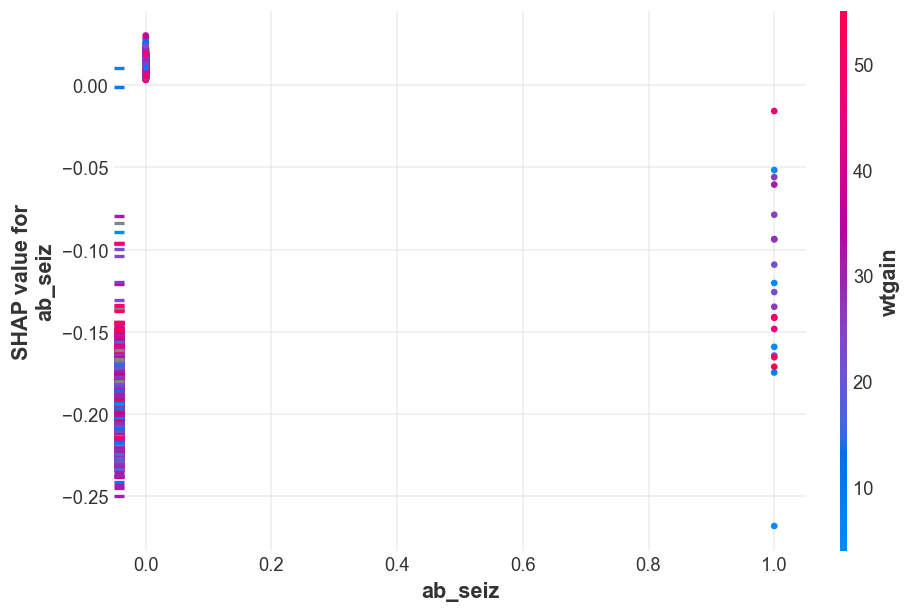


Feature: no_risks


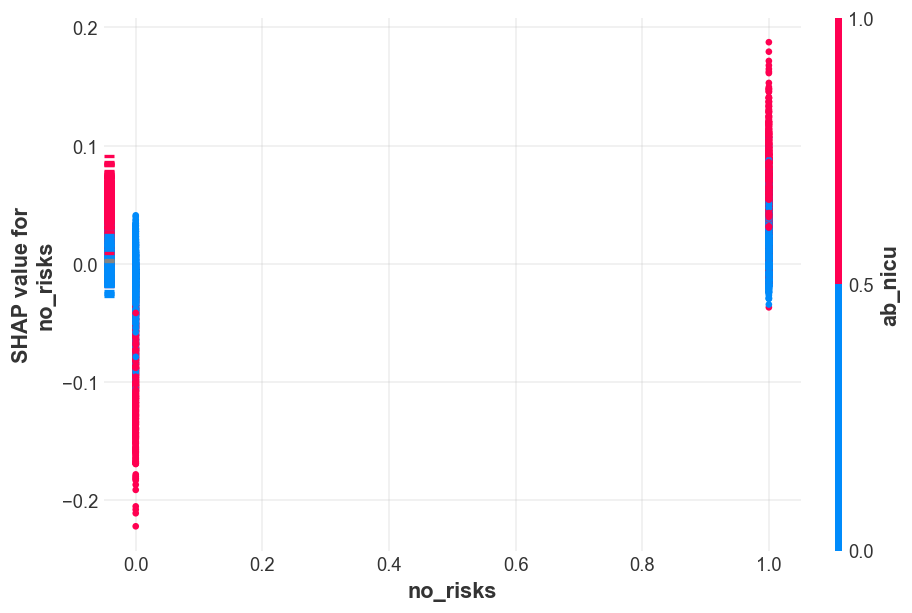


Feature: ld_indl


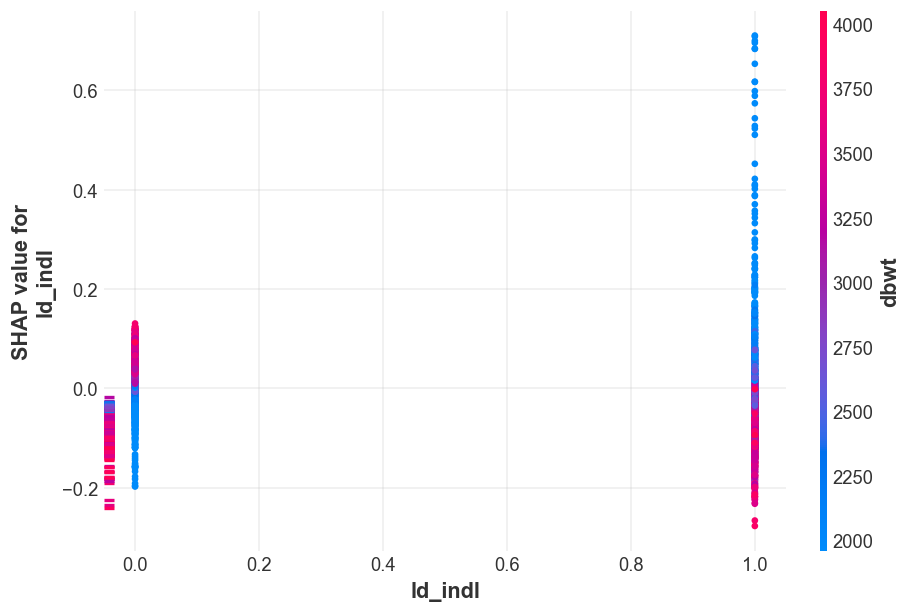


Feature: me_pres


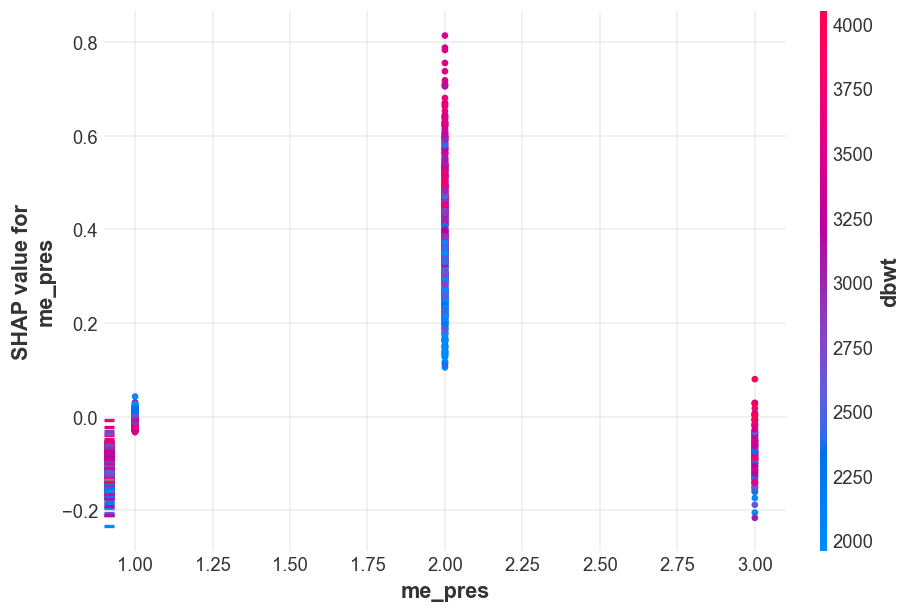


Feature: dmeth_rec


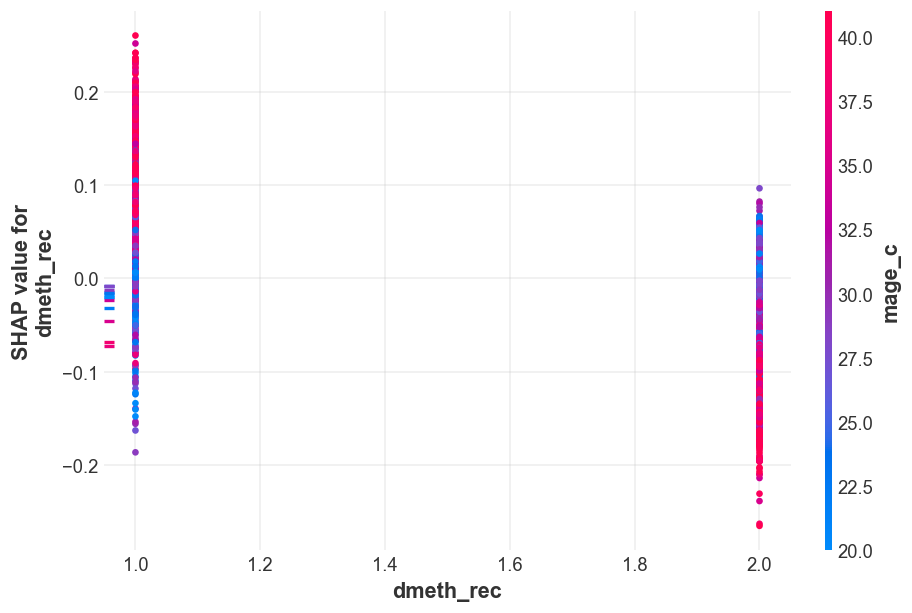


Feature: sex


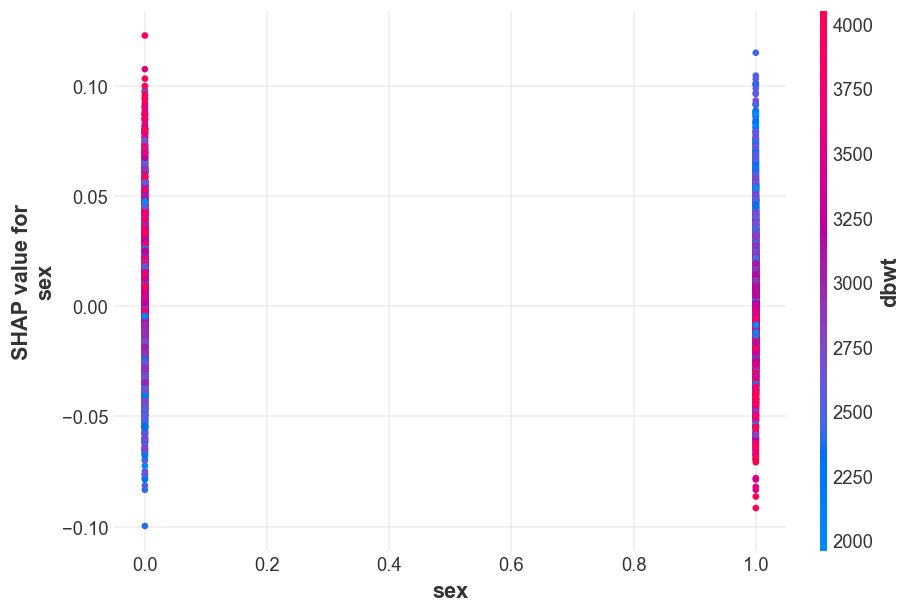


Feature: ca_disor


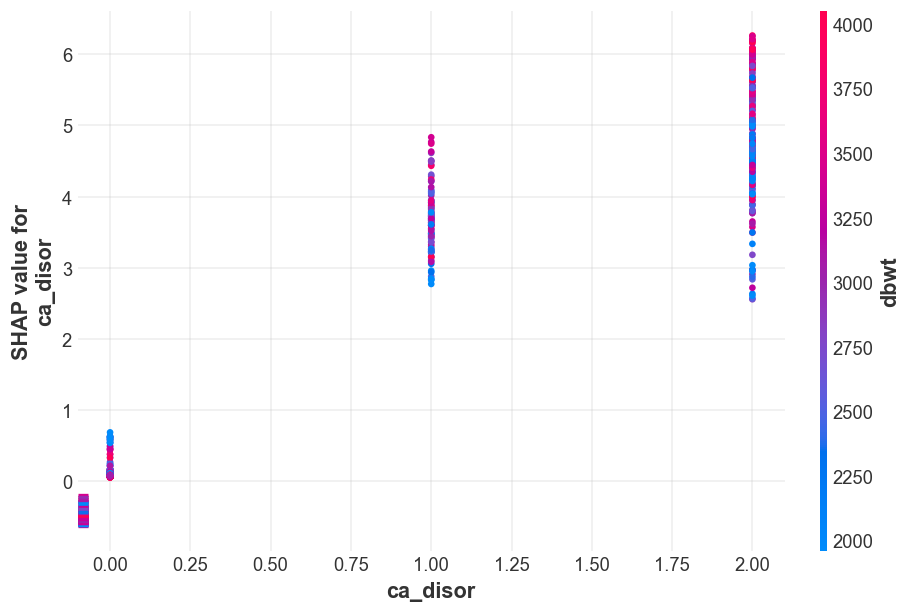


Feature: ca_cchd


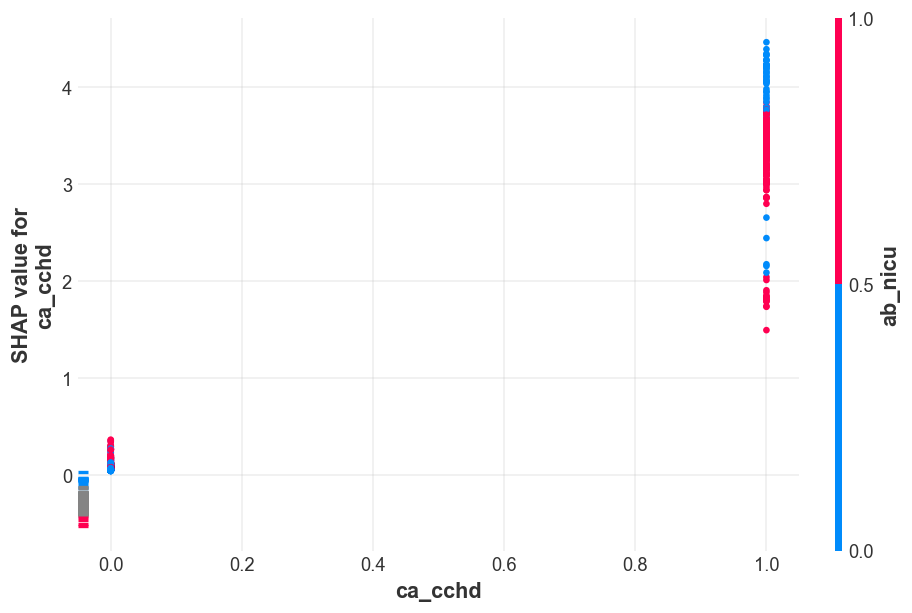


Feature: ca_cdh


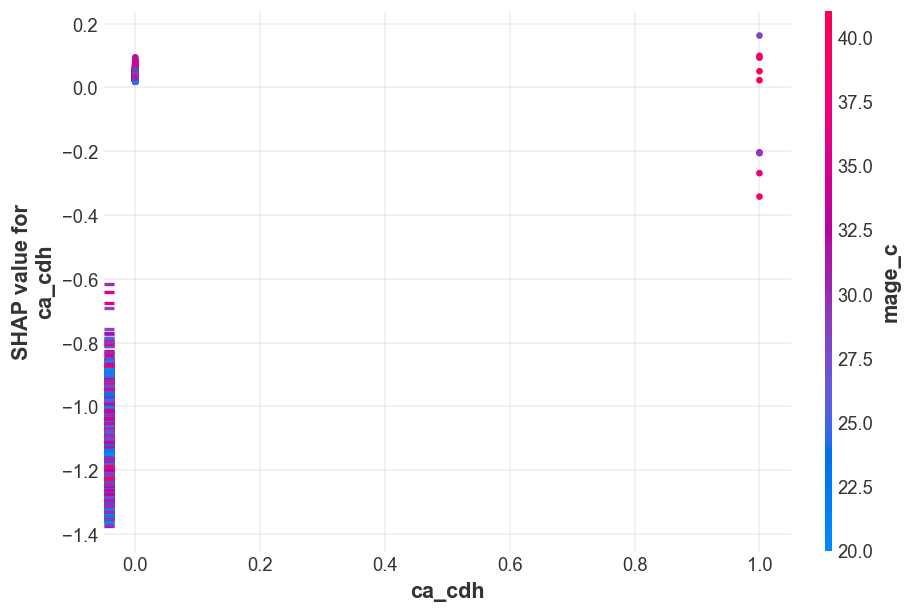


Feature: ca_omph


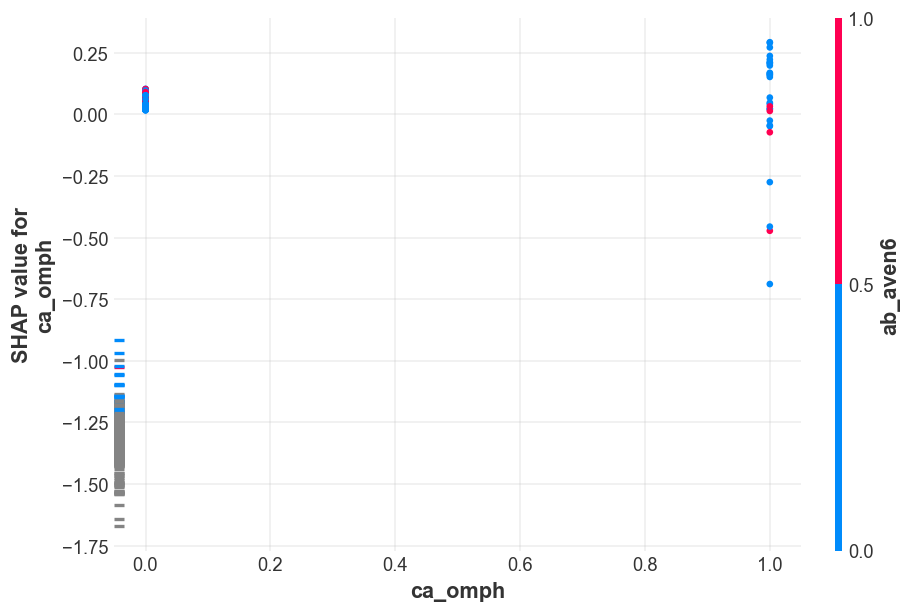


Feature: bmi


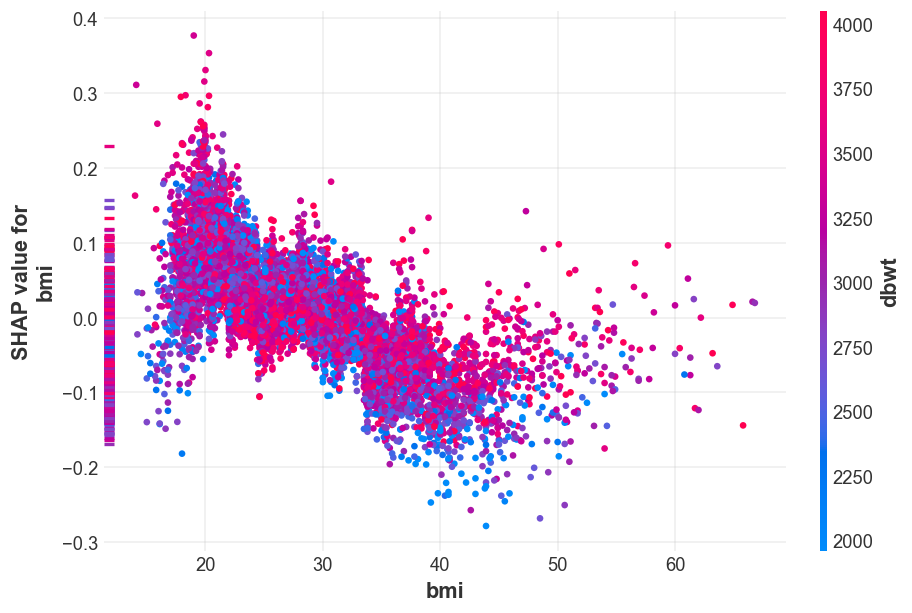


Feature: pay_rec


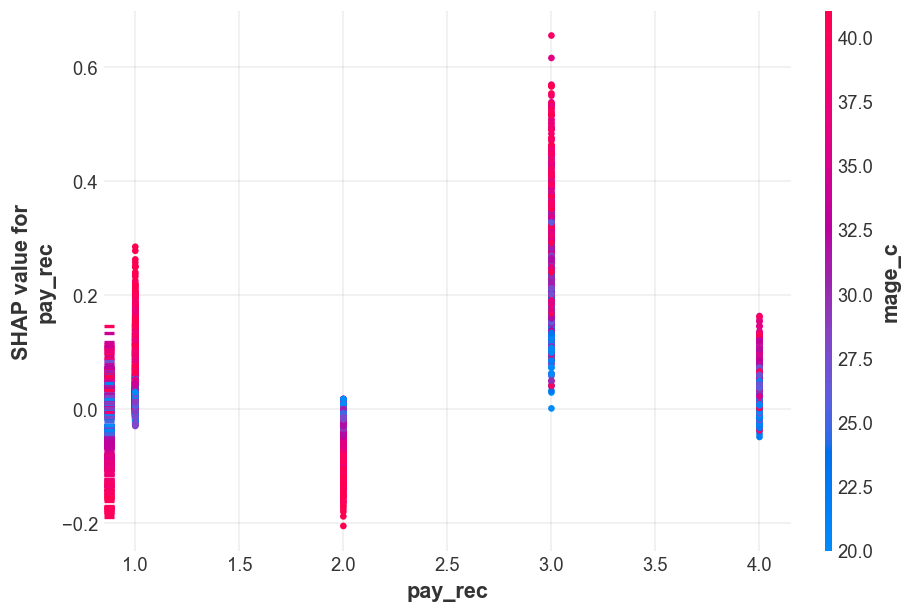


Feature: wic


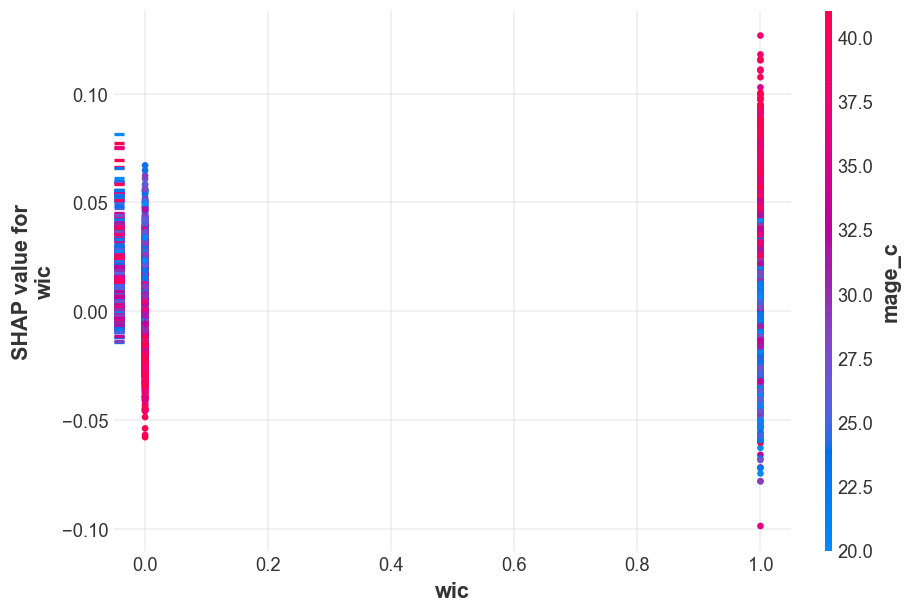

In [20]:
X_shap_fp = X_shap.astype("float32")
for name in X_shap_fp.columns:
    print(f"\nFeature: {name}")
    shap.dependence_plot(name, shap_values, X_shap_fp)